In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('Items Shipped by Item by Month.csv')

In [123]:
df.head()

,Date,Item,Item Description,Product Group,Parent Product Group,Quantity,Amount
0,2024-Sep,2151,Original 36in Griddle W/Hood,Griddles,Cooking Unit,168.0,42504.00
1,2024-Sep,5482SA,"36"" Griddle with hood cover - Saudi Arabia",Covers/Bags - GRD,Accessory,297.0,6073.65
2,2024-Sep,5483SA,"28"" GRIDDLE COVER - Saudi Arabia",Covers/Bags - GRD,Accessory,297.0,5702.40
3,2024-Sep,2370,28in Omnivore Original Series Griddle,Griddles,Cooking Unit,2668.0,276184.42
4,2024-Sep,2370,28in Omnivore Original Series Griddle,Griddles,Cooking Unit,3654.0,378252.58


In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383972 entries, 0 to 383971
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Date                  383972 non-null  object 
 1   Item                  383972 non-null  object 
 2   Item Description      382044 non-null  object 
 3   Product Group         376304 non-null  object 
 4   Parent Product Group  383972 non-null  object 
 5   Quantity              383001 non-null  float64
 6   Amount                383972 non-null  float64
dtypes: float64(2), object(5)
memory usage: 20.5+ MB


In [125]:
df['Date'] = pd.to_datetime(df['Date'])

In [126]:
item = '4109'

df = df.groupby(['Date','Item'])['Quantity'].sum().reset_index().sort_values(by='Date', ascending=True)

df_item = df[df['Item'] == item]

df_item = df_item.resample('M', on='Date').sum().reset_index()

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56556 entries, 0 to 56555
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      56556 non-null  datetime64[ns]
 1   Item      56556 non-null  object        
 2   Quantity  56556 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.7+ MB


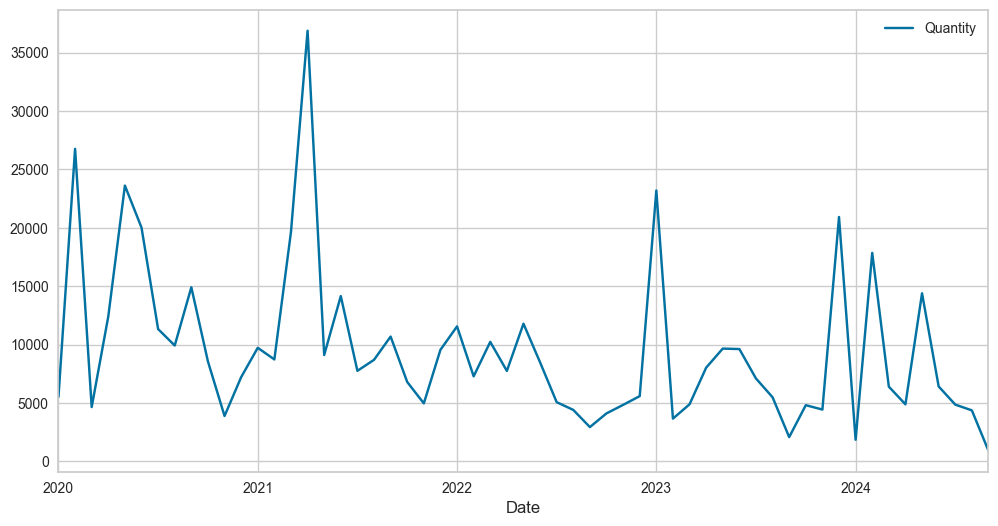

In [128]:
# Plot the time series data
df_item.plot(x='Date', y='Quantity', figsize=(12,6))
unchanged_df = df_item.copy()

## Data Transformation

### Box Cox Transformation

In [129]:
from scipy.stats import boxcox

        Date  Quantity  boxcox_units
0 2020-01-31    5533.0     14.371131
1 2020-02-29   26759.0     18.813491
2 2020-03-31    4658.0     13.930978
3 2020-04-30   12415.0     16.552733
4 2020-05-31   23612.0     18.432024
The optimal lambda for Box-Cox transformation is: 0.11002474297533488


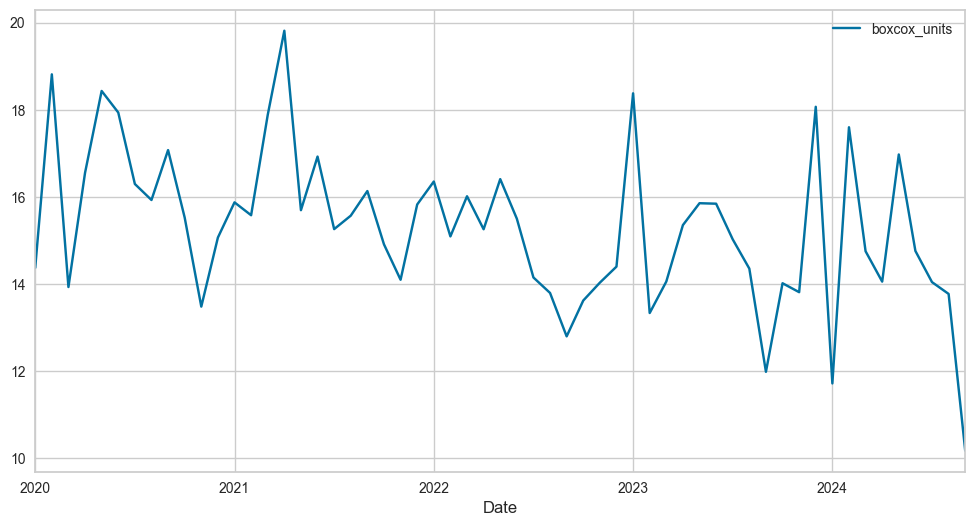

In [130]:

# Apply Box-Cox transformation to find the optimal lambda
df_item['boxcox_units'] , optimal_lambda = boxcox(df_item.Quantity)
print(df_item.head())
box_cox_df = df_item.copy()

# Plot the transformed data with optimal lambda
df_item.plot(x='Date', y='boxcox_units', figsize=(12,6))

# Print the optimal lambda
print(f'The optimal lambda for Box-Cox transformation is: {optimal_lambda}')

## ACF and PACF

In [131]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

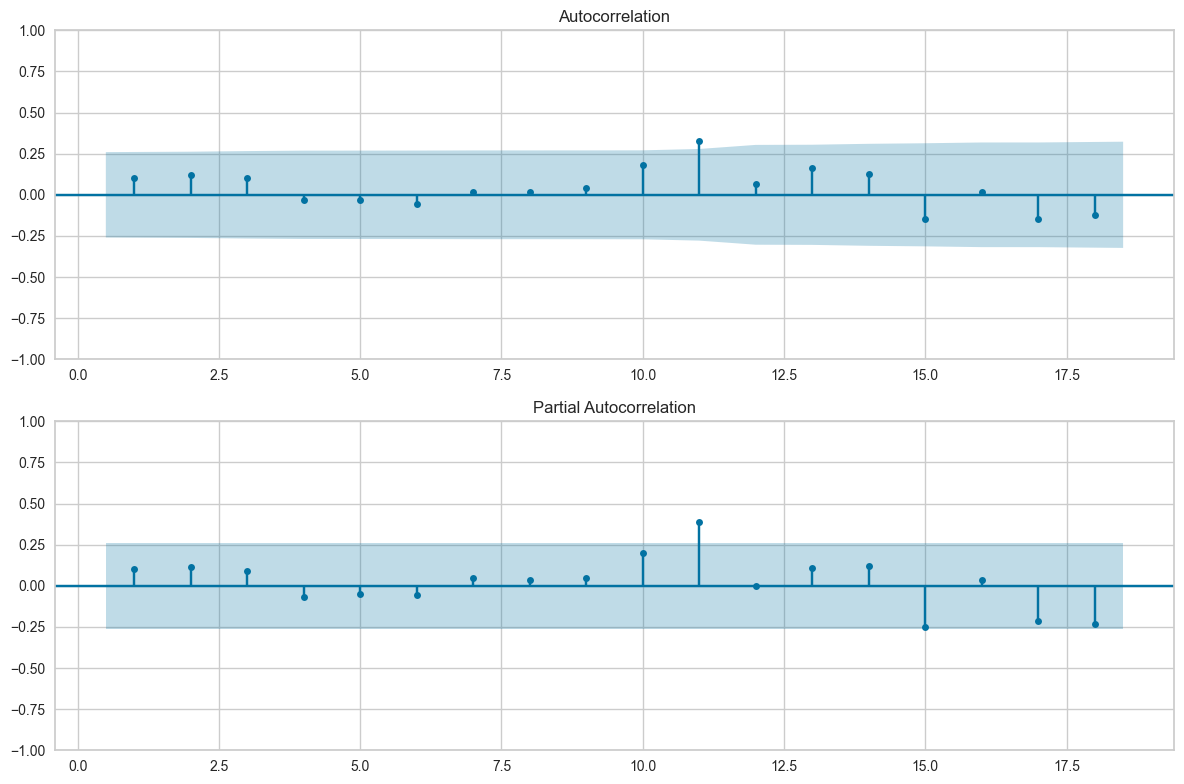

In [132]:
# Plot ACF and PACF for the original airline passenger data
plt.figure(figsize=(12, 8))
plt.subplot(211)
plot_acf(df_item['Quantity'], ax=plt.gca(), zero=False)
plt.subplot(212)
plot_pacf(df_item['Quantity'], ax=plt.gca(), zero=False)
plt.tight_layout()
plt.show()

## Stationarity

In [133]:
from statsmodels.tsa.stattools import adfuller

In [134]:
# Function to perform ADF test
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Test Statistic', 'p-value', '# Lags Used', 'Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    print(out.to_string())
    if result[1] <= 0.05:
        print("=> The series is stationary.")
    else:
        print("=> The series is non-stationary.")

# Apply the ADF test to the original data
adf_test(df_item['Quantity'], title='Original')

Augmented Dickey-Fuller Test: Original
ADF Test Statistic            -6.551487e+00
p-value                        8.828299e-09
# Lags Used                    0.000000e+00
Number of Observations Used    5.600000e+01
Critical Value (1%)           -3.552928e+00
Critical Value (5%)           -2.914731e+00
Critical Value (10%)          -2.595137e+00
=> The series is stationary.


Augmented Dickey-Fuller Test: boxcox quantity- Differenced
ADF Test Statistic            -5.661308e+00
p-value                        9.366171e-07
# Lags Used                    9.000000e+00
Number of Observations Used    4.600000e+01
Critical Value (1%)           -3.581258e+00
Critical Value (5%)           -2.926785e+00
Critical Value (10%)          -2.601541e+00
=> The series is stationary.


<Axes: xlabel='Date'>

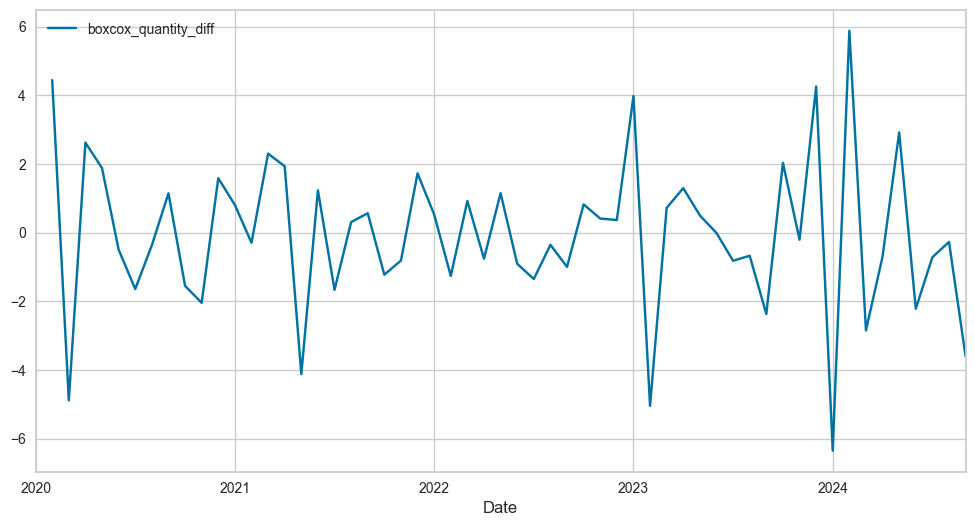

In [135]:
df_item['boxcox_quantity_diff'] = df_item['boxcox_units'].diff()

# Perform ADF test on differenced data
adf_test(df_item['boxcox_quantity_diff'].dropna(), title='boxcox quantity- Differenced')

# Plot the differenced data
df_item.plot(x='Date', y='boxcox_quantity_diff', figsize=(12,6))

## Benchmarking

#### Multi-Horizon Benchmark

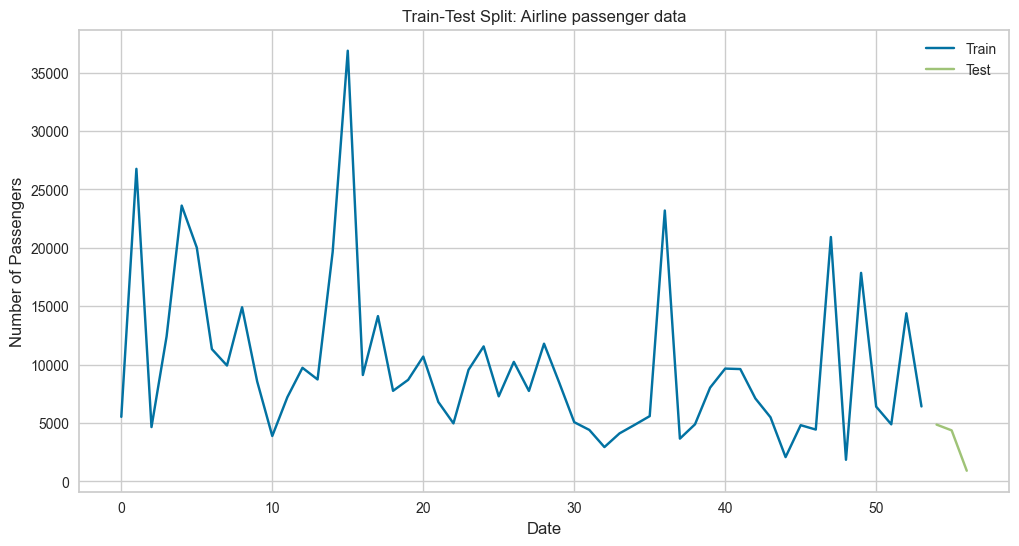

In [136]:
# Split the data
train = df_item[['Quantity']][:-3]
test = df_item[['Quantity']][-3:]

# Visualize the train and test data
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.title('Train-Test Split: Airline passenger data')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

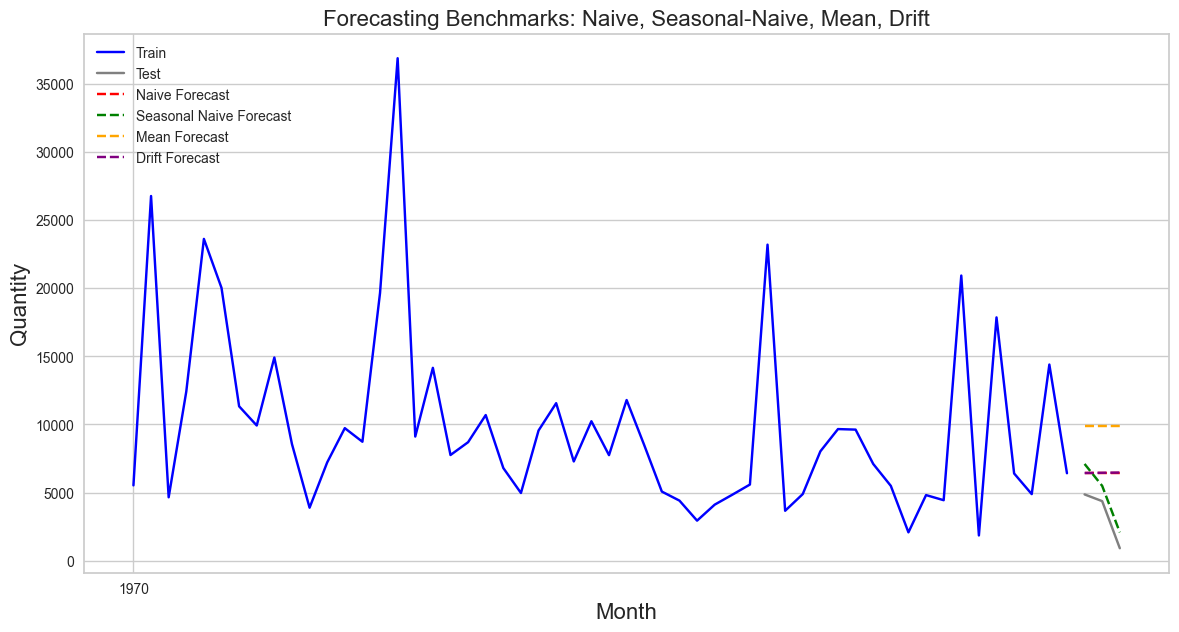

In [137]:
# Naive Forecast
# The naive forecaster simply uses the last observation from the training set
# as the forecast for all future observations.
y_hat_naive = test.copy()
y_hat_naive['naive'] = train.iloc[-1]['Quantity']

# Seasonal Naive Forecast:
# The seasonal naive forecaster uses the observation 
# from the same season of the previous cycle as the forecast.
season_length = 12
train_values_for_snaive = train['Quantity'].values[-season_length:]  # Last season's data
y_hat_snaive = test.copy()
y_hat_snaive['snaive'] = np.tile(train_values_for_snaive, len(test)//season_length+1)[:len(test)]

# Mean Forecast:
# The mean forecaster uses the mean of the training set as the forecast for all future observations.
y_hat_mean = test.copy()
y_hat_mean['mean'] = train['Quantity'].mean()

# Drift Forecast:
# The drift forecaster extrapolates a line between the first and last observations
# in the training set.
y_hat_drift = test.copy()
num_periods = len(train) - 1
drift = (train['Quantity'].iloc[-1] - train['Quantity'].iloc[0]) / num_periods
y_hat_drift['drift'] = [train['Quantity'].iloc[-1] + (i+1) * drift for i in range(len(test))]


# Ensure index types are correct
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)
y_hat_naive.index = pd.to_datetime(y_hat_naive.index)
y_hat_snaive.index = pd.to_datetime(y_hat_snaive.index)
y_hat_mean.index = pd.to_datetime(y_hat_mean.index)
y_hat_drift.index = pd.to_datetime(y_hat_drift.index)

# Visualization
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['Quantity'], label='Train', color='blue')
plt.plot(test.index, test['Quantity'], label='Test', color='grey')
plt.plot(y_hat_naive.index, y_hat_naive['naive'], label='Naive Forecast', color='red', linestyle='--')
plt.plot(y_hat_snaive.index, y_hat_snaive['snaive'], label='Seasonal Naive Forecast', color='green', linestyle='--')
plt.plot(y_hat_mean.index, y_hat_mean['mean'], label='Mean Forecast', color='orange', linestyle='--')
plt.plot(y_hat_drift.index, y_hat_drift['drift'], label='Drift Forecast', color='purple', linestyle='--')

plt.title('Forecasting Benchmarks: Naive, Seasonal-Naive, Mean, Drift', fontsize=16)
plt.xlabel('Month',fontsize=16)
plt.ylabel('Quantity',fontsize=16)
plt.legend(loc='upper left')
plt.show()

#### One Step ahead benchmark

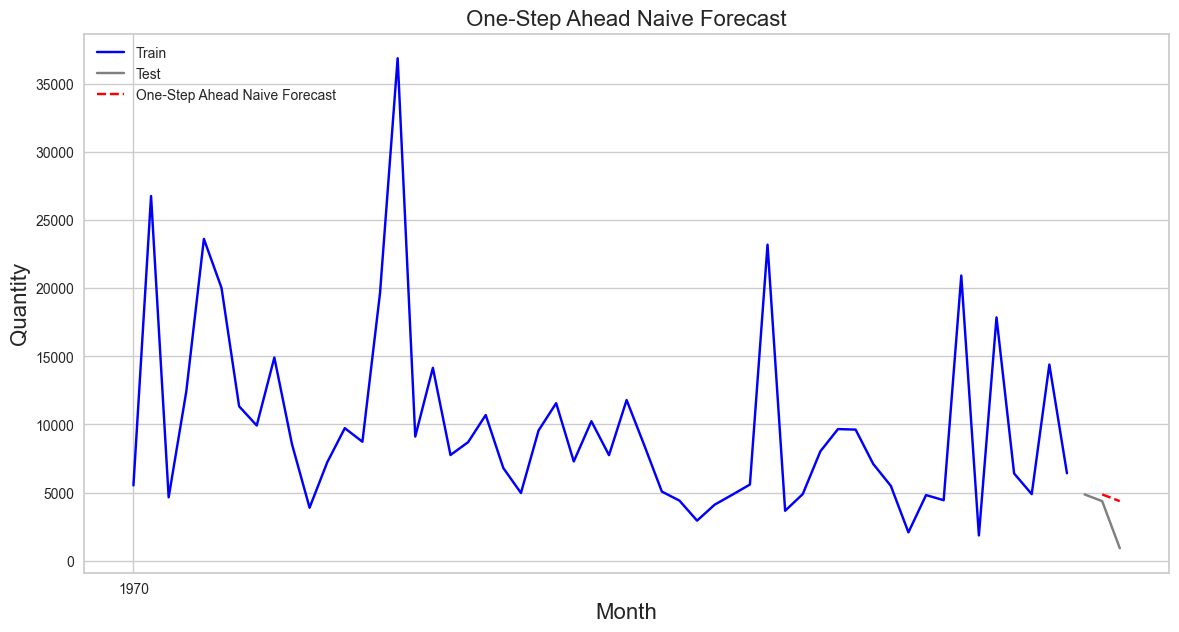

In [138]:
# Correcting the Naive Forecast for a true one-step ahead visualization
y_hat_naive_corrected = df_item.copy()
y_hat_naive_corrected['naive_one_step'] = df_item['Quantity'].shift(1)

# Adjusting visualization to focus on one-step ahead naive forecast in the test set
plt.figure(figsize=(14, 7))

# Original data (Train and Test)
plt.plot(train.index, train['Quantity'], label='Train', color='blue')
plt.plot(test.index, test['Quantity'], label='Test', color='grey')

# One-step ahead naive forecast (Test set only)
# Shifting the test data one step for the naive forecast
test_shifted_for_naive = test['Quantity'].shift(1)
plt.plot(test.index, test_shifted_for_naive, label='One-Step Ahead Naive Forecast', color='red', linestyle='--')

plt.title('One-Step Ahead Naive Forecast', fontsize=16)
plt.xlabel('Month', fontsize=16)
plt.ylabel('Quantity',fontsize=16)
plt.legend(loc='upper left')
plt.show()

## Pycaret Forecast

In [139]:
from pycaret.time_series import *

In [140]:
df_item.head()

,Date,Quantity,boxcox_units,boxcox_quantity_diff
0,2020-01-31,5533.0,14.371131,NaN
1,2020-02-29,26759.0,18.813491,4.442360
2,2020-03-31,4658.0,13.930978,-4.882514
3,2020-04-30,12415.0,16.552733,2.621755
4,2020-05-31,23612.0,18.432024,1.879291


In [141]:
df_item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  57 non-null     datetime64[ns]
 1   Quantity              57 non-null     float64       
 2   boxcox_units          57 non-null     float64       
 3   boxcox_quantity_diff  56 non-null     float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.9 KB


In [142]:
df_item = df_item.drop(columns = ['Quantity','boxcox_units'])
df_item = df_item.set_index('Date')
df_item.tail()

,boxcox_quantity_diff
Date,
2024-05-31,2.918883
2024-06-30,-2.214515
2024-07-31,-0.715845
2024-08-31,-0.270687
2024-09-30,-3.599547


In [143]:
exp = TSForecastingExperiment()
exp.setup(data = df_item, target='boxcox_quantity_diff', numeric_imputation_target='mean', fh=3)

,Description,Value
0,session_id,5799
1,Target,boxcox_quantity_diff
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(57, 1)"
5,Transformed data shape,"(57, 1)"
6,Transformed train set shape,"(54, 1)"
7,Transformed test set shape,"(3, 1)"
8,Rows with missing values,1.8%
9,Fold Generator,ExpandingWindowSplitter


In [144]:
exp.check_stats()

,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,57.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,-0.074963
3,Summary,Statistics,Transformed,Median,,-0.204996
4,Summary,Statistics,Transformed,Standard Deviation,,2.300154
5,Summary,Statistics,Transformed,Variance,,5.290708
6,Summary,Statistics,Transformed,Kurtosis,,0.957185
7,Summary,Statistics,Transformed,Skewness,,-0.155892
8,Summary,Statistics,Transformed,# Distinct Values,,57.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",37.727857


#### Comparing Models

In [145]:
best = exp.compare_models()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,0.9300,0.7587,2.2568,2.5696,0.9075,1.5259,-0.1027,0.0600
catboost_cds_dt,CatBoost Regressor w/ Cond. Deseasonalize & Detrending,1.0287,0.8159,2.5162,2.8030,1.6672,1.2790,-0.2079,0.4267
auto_arima,Auto ARIMA,1.0443,0.8686,2.5457,2.9502,0.8864,1.6570,-0.1793,0.2067
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,1.1217,0.8910,2.7651,3.0622,1.1084,1.4311,-0.5957,0.0833
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,1.2016,0.9222,3.0291,3.2733,1.8037,1.5314,-1.0706,0.0833
arima,ARIMA,1.2108,0.9517,2.9914,3.2790,1.2178,1.5330,-0.5216,0.0367
knn_cds_dt,K Neighbors w/ Cond. Deseasonalize & Detrending,1.2481,0.9514,2.9940,3.1885,1.1934,1.7083,-0.3656,0.0533
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,1.2597,0.9851,3.0826,3.3667,1.2761,1.7000,-0.6103,0.0467
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,1.2619,0.9803,3.1040,3.3690,1.3959,1.6554,-0.6599,0.0433
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,1.2619,0.9803,3.1040,3.3690,1.3959,1.6554,-0.6599,0.0467


In [146]:
tuned = exp.tune_model(best)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2023-09,1.4044,1.1513,3.1708,3.6766,2.4476,1.7958,-3.0759
1,2023-12,1.4510,1.0717,3.4095,3.4710,0.8109,1.1396,0.5444
2,2024-03,0.8357,0.6141,2.3734,2.5041,1.3805,2.0000,-0.3524
Mean,NaT,1.2304,0.9457,2.9846,3.2173,1.5463,1.6451,-0.9613
SD,NaT,0.2797,0.2367,0.4430,0.5112,0.6784,0.3671,1.5395


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.2s finished


#### Finalizing Model

In [147]:
final = exp.finalize_model(tuned)

In [148]:
exp.plot_model(final, plot='forecast', data_kwargs={'fh':3})

In [149]:

unseen_predictions = exp.predict_model(final, fh=3)
unseen_predictions

,y_pred
2024-10,-0.0874
2024-11,-0.2132
2024-12,-0.2244


#### Reversing Transformation

In [150]:
from scipy.special import inv_boxcox


last_original_value = box_cox_df['boxcox_units'].iloc[-1]
last_original_value

10.173224753762486

In [151]:
# Reverse differencing (undo stationarity)
reversed_diff_predictions = unseen_predictions.cumsum() + last_original_value
reversed_diff_predictions


,y_pred
2024-10,10.085825
2024-11,9.872625
2024-12,9.648225


In [152]:
# Example lambda value for Box-Cox transformation
boxcox_lambda = optimal_lambda

# Reverse Box-Cox transformation
original_scale_predictions = inv_boxcox(reversed_diff_predictions, boxcox_lambda)
original_scale_predictions

,y_pred
2024-10,884.667149
2024-11,799.181408
2024-12,717.221080


In [153]:
unchanged_df.index = unchanged_df['Date']
unchanged_df = unchanged_df.drop(columns = ['Date'])
unchanged_df.tail()

,Quantity
Date,
2024-05-31,14396.0
2024-06-30,6423.0
2024-07-31,4869.0
2024-08-31,4375.0
2024-09-30,922.0


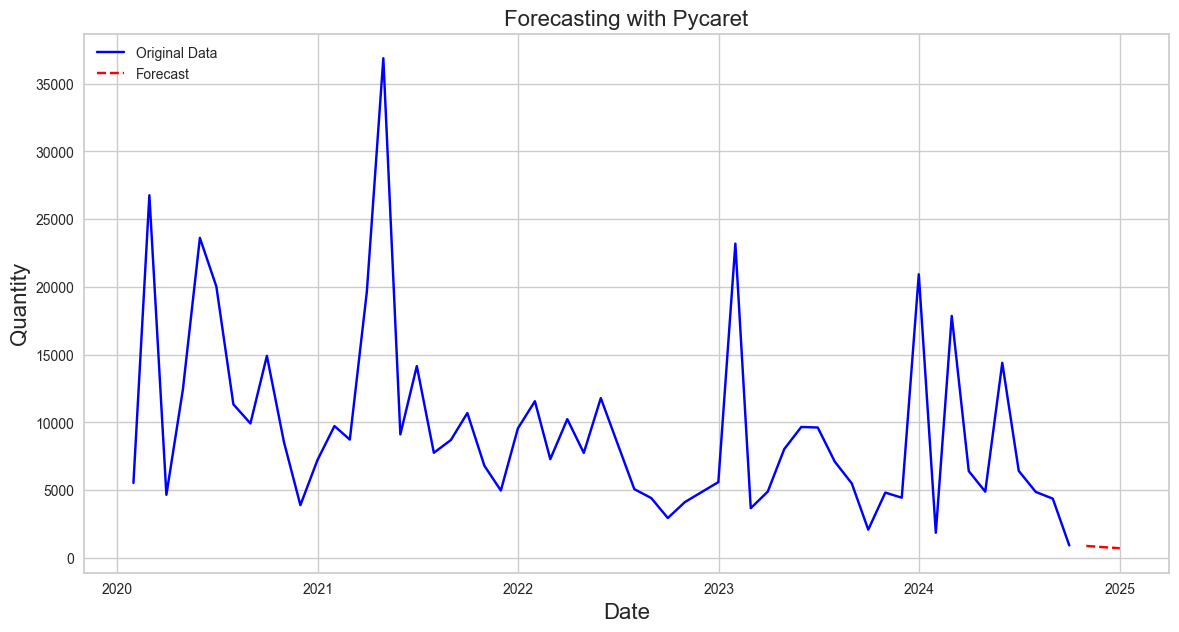

In [154]:
# plot original data and forecast
plt.figure(figsize=(14, 7))
plt.plot(unchanged_df.index, unchanged_df['Quantity'], label='Original Data', color='blue')
plt.plot(original_scale_predictions.index, original_scale_predictions, label='Forecast', color='red', linestyle='--')
plt.title('Forecasting with Pycaret', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Quantity', fontsize=16)
plt.legend(loc='upper left')
plt.show()